In [1]:
# %load_ext blackcellmagic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import root_scalar
# plt.style.use("ggplot")
plt.rcParams['font.family'] = "serif"
plt.rc('text', usetex=True)
from numba import jit, njit

#  Pogledamo kvadratno opno:

In [2]:
N = 40
h = 1 / (N + 1)


def UU(N: int):
    """Construct a symmetric matrix A for twodimensional vibration modes on square geometry."""
    U = np.zeros((N ** 2, N ** 2))
    for i in range(N * N):
        U[i][i] = 4
    for i in range(0, N * N - 1):
        if ((N - 1) * i - 1) % N == 0:
            U[i][i + 1] = 0
            U[i + 1][i] = 0
        else:
            U[i][i + 1] = -1
            U[i + 1][i] = -1
    for i in range(N * N - N):
        U[i + N][i] = -1
        U[i][i + N] = -1
    return U


A = UU(N)
eigenvalues, eigenvectors = scipy.linalg.eigh(A)

In [3]:
eigenvalues, eigenvectors = scipy.linalg.eigh(A)
eigenvalues_sparse, eigenvectors_sparse = scipy.sparse.linalg.eigsh(A, which="SM", k=1600)

/home/peter/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1593: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [4]:
eigenvalues.shape

(1600,)

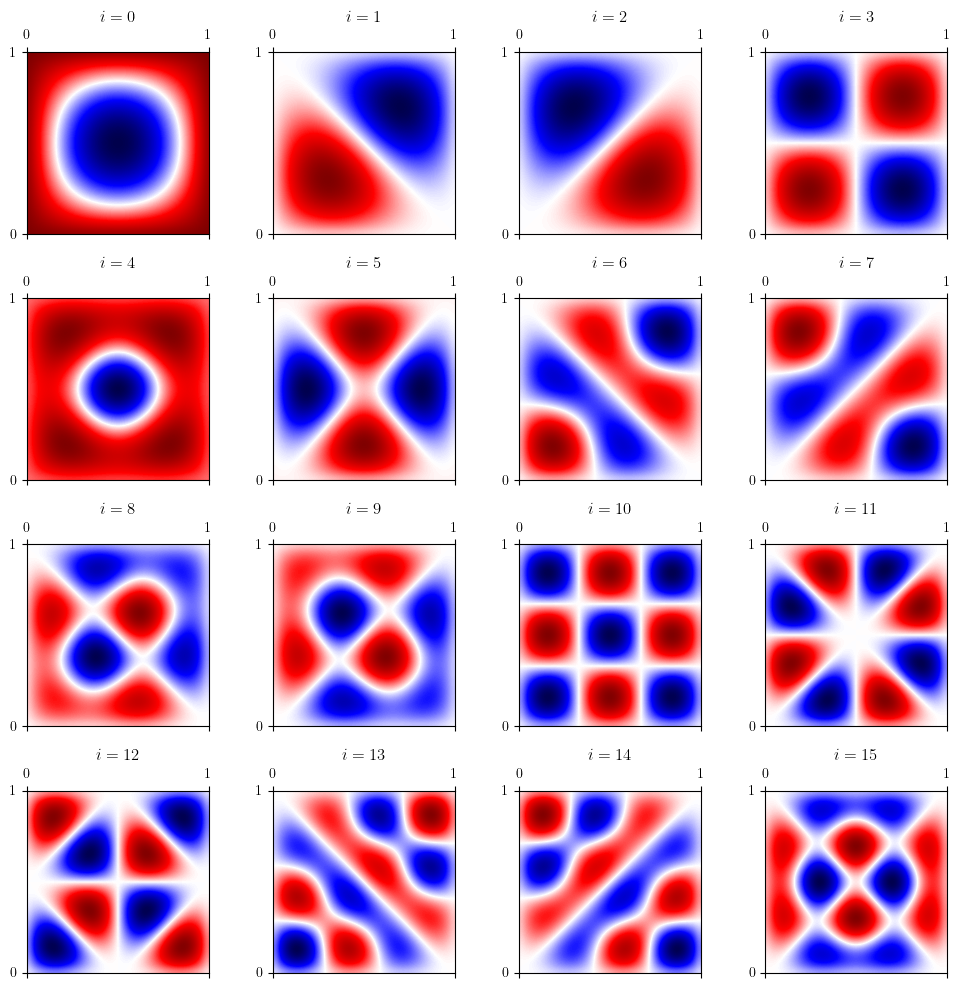

In [5]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
axes = axes.reshape(-1)
for i in range(16):
    axes[i].matshow(
        eigenvectors_sparse[:, i].reshape((N, -1)),
        extent=((0, 1, 0, 1)),
        cmap="seismic",
        interpolation="bicubic",
    )
    axes[i].set_title(fr"$i={{{i}}}$")
plt.tight_layout()
plt.savefig("1-0-nihajni_nacini_sparse.pdf")
plt.show()

In [6]:
eigenvalues.shape

(1600,)

In [7]:
np.allclose(eigenvalues_sparse[:16], eigenvalues[:16])

True

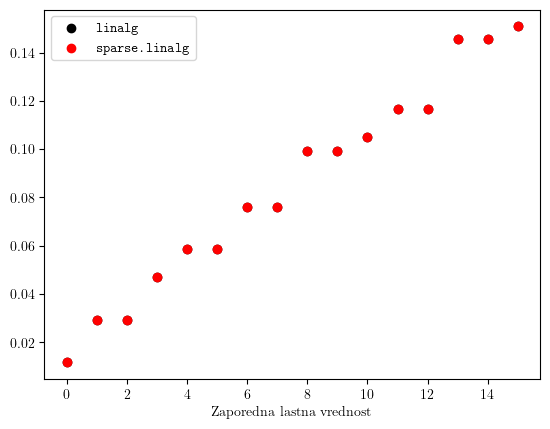

In [8]:
%matplotlib inline
plt.scatter(np.arange(0, 16 ,1), eigenvalues[:16], c="k", label=r"\texttt{linalg}")
plt.scatter(np.arange(0, 16, 1), eigenvalues_sparse[:16], c="r", label=r"\texttt{sparse.linalg}")
plt.xlabel("Zaporedna lastna vrednost")
plt.legend()
plt.savefig("1-0-spekter-zoom.pdf")
plt.show()

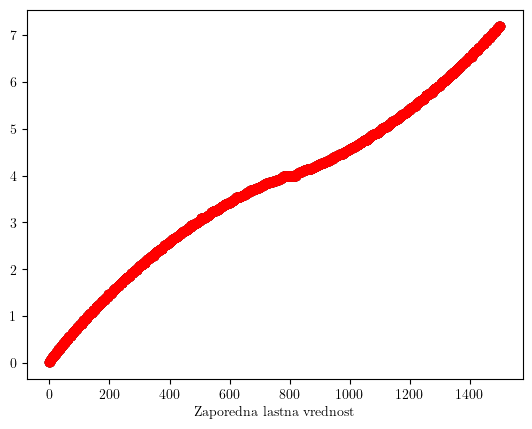

In [9]:
M = 1500
plt.scatter(np.arange(0, M ,1), eigenvalues[:M], c="k", label="linag")
plt.scatter(np.arange(0, M ,1), eigenvalues_sparse[:M], c="r", label="sparse.linalg")
plt.xlabel("Zaporedna lastna vrednost")
#plt.savefig("1-0-spekter.pdf")
plt.show()

## Nadaljujmo, torej, dragi bralec, k potenčni metodi, za isto kvadratno opno:

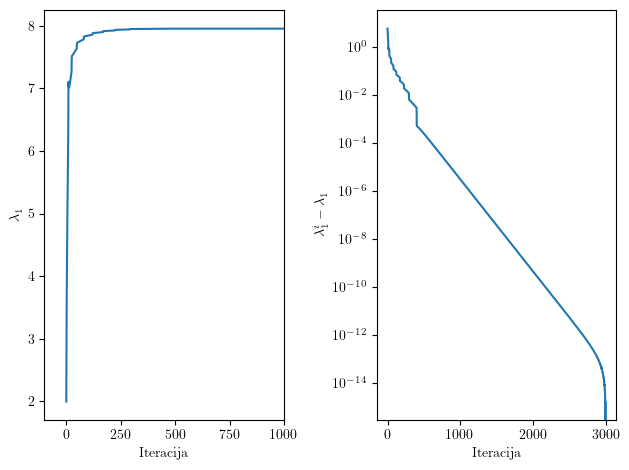

In [10]:

def power_method(A, num_iter=1000):
    values = np.empty(num_iter, dtype=float)
    b = np.full(A.shape[0], 1.0)
    for i in range(num_iter):
        prod = np.dot(A, b)
        norm = np.max(prod)
        #print(b, norm)
        b = prod / norm
        values[i] = norm
    return norm, values
value, potek = power_method(A)


fig, [ax1, ax2] = plt.subplots(ncols=2)
ax1.set_xlabel(r"Iteracija")
ax1.set_ylabel(r"$\lambda_1$")
ax1.set_xlim((-100, 1000))
# ax1.set_yscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(r"Iteracija")
ax2.set_ylabel(r"$\lambda_1^i - \lambda_1$")


value, potek = power_method(A, num_iter=3000)
ax1.plot(potek, )
ax2.plot(np.abs(potek[-1] - potek))


plt.tight_layout()
plt.savefig("1-0-powermethod.pdf")
plt.show()

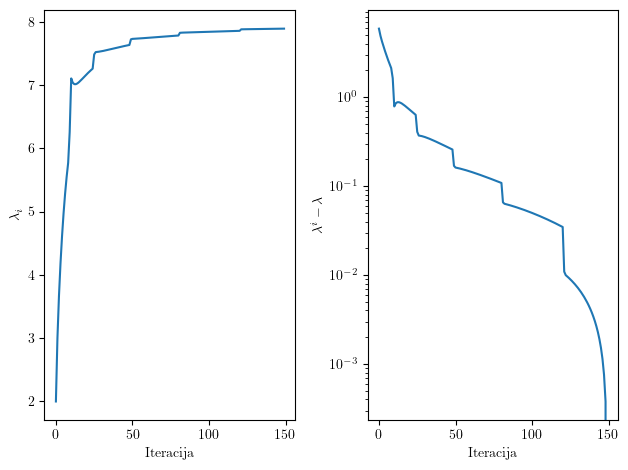

In [11]:
@jit
def inverse_power_method(A, sigma, num_iter=1000):
    values = np.zeros(num_iter, dtype=float)
    b = np.full(A.shape[0], 1.0)
    for i in range(num_iter):
        # print(i, end="\r")
        mat = np.linalg.inv(A - sigma * np.identity(A.shape[0]))
        prod = np.dot(A, b)
        norm = np.max(prod)
        #print(b, norm)
        b = prod / norm
        values[i] = norm
    return norm, values





fig, [ax1, ax2] = plt.subplots(ncols=2)
ax1.set_xlabel(r"Iteracija")
ax1.set_ylabel(r"$\lambda_i$")
#ax1.set_xlim((-100, 1000))
# ax1.set_yscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(r"Iteracija")
ax2.set_ylabel(r"$\lambda^i - \lambda$")


value, potek = inverse_power_method(A, 8, num_iter=150)
ax1.plot(potek, )
ax2.plot(np.abs(potek[-1] - potek))


plt.tight_layout()
plt.savefig("1-0-inverse_powermethod.pdf")
plt.show()

In [19]:

sigmas = np.linspace(0, 8, 8)
eigenvalues_inverse = np.zeros_like(sigmas)
from concurrent.futures import ProcessPoolExecutor
def f(sigma):
    return inverse_power_method(A, sigma, num_iter=50)[1][-1]
with ProcessPoolExecutor(max_workers = 4) as executor:
    eigenvalues_inverse = list(executor.map(f, sigmas.tolist()))



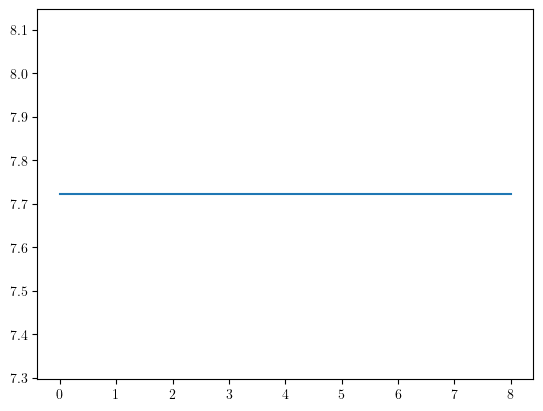

In [20]:
plt.plot(sigmas, eigenvalues_inverse)

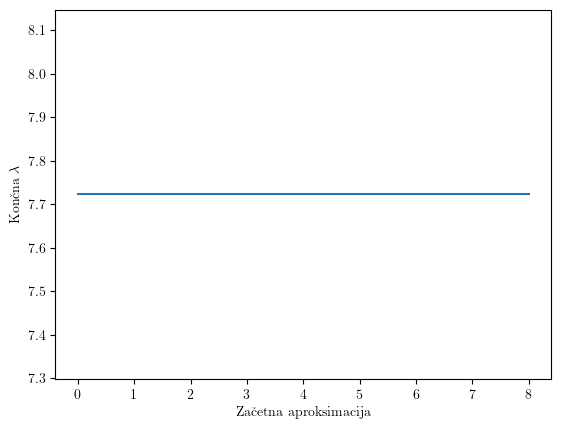

In [21]:
fig, ax = plt.subplots()
ax.plot(sigmas, eigenvalues_inverse)
ax.set_xlabel("Začetna aproksimacija")
ax.set_ylabel(r"Končna $\lambda$")
plt.savefig("1-0-inverse_powermethod_sweep.pdf")
plt.show()

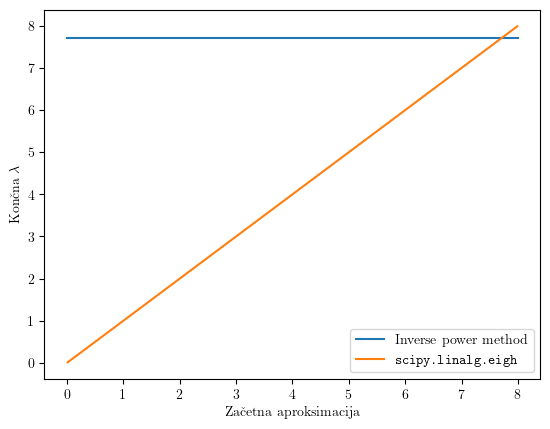

In [22]:
fig, ax = plt.subplots()
ax.plot(sigmas, eigenvalues_inverse, label = "Inverse power method")
ax.plot(eigenvalues, eigenvalues, label = r"\texttt{scipy.linalg.eigh}")
ax.set_xlabel("Začetna aproksimacija")
ax.set_ylabel(r"Končna $\lambda$")
plt.legend()
plt.savefig("1-0-inverse_powermethod_sweep_comparison.pdf")
plt.show()

In [23]:
# def inverse_power_method(A, sigma, num_iter=1000):
#     values = np.zeros(num_iter, dtype=float)
#     b = np.full(A.shape[0], 3)
#     for i in range(num_iter):
#         mat = np.linalg.inv(A - sigma * np.identity(A.shape[0]))
#         prod = np.dot(A, b)
#         norm = np.max(prod)
#         #norm = np.linalg.norm(prod)
#         #print(b, norm)
#         b = prod / norm
#         values[i] = norm
#         sigma = np.dot(b.T, np.dot(A, b))
#     return norm, values
# AA = np.array([[-4, 14, 0],
#                [-5, 13, 0],
#                [-1, 0, 2]])
# sigmas = np.linspace(-300, 1000, 200)
# values = np.zeros_like(sigmas)
# for i, sigma in enumerate(sigmas):
#     value, _ = inverse_power_method(AA, sigma, num_iter=10)
#     values[i] = value

In [24]:
# plt.plot(sigmas, values)
# plt.show()

#  Implementacija različnih gostot

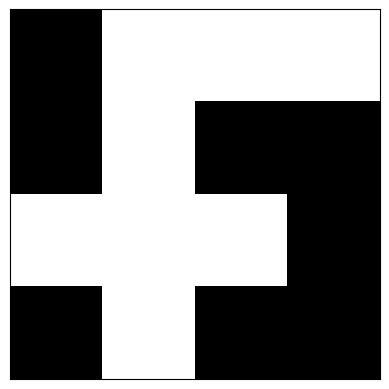

In [25]:
def make_B(A, ro1, ro2):
    N = int(np.sqrt(A.shape[0]))
    b_mat = np.zeros((N,N))
    lookup = {
        (0,0) : ro1,
        (1,0) : ro1,
        (3,0) : ro1,
        (1,2) : ro1,
        (1,3) : ro1,
        (3,3) : ro1,
        (3,2) : ro1,
        (2,3) : ro1
    }
    for i in range(N):
        for j in range(N):
            x = (4 * i)//N
            y = (4 * j)//N
            b_mat[j, i] = lookup.get((y,x), ro2)
    return b_mat
b_mat = make_B(A, 1, 2)
fig, ax = plt.subplots()
ax.matshow(b_mat, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
plt.box(True)
plt.savefig("1-figura.pdf")
plt.show()



In [26]:
b = np.diag(make_B(A, 1,10).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

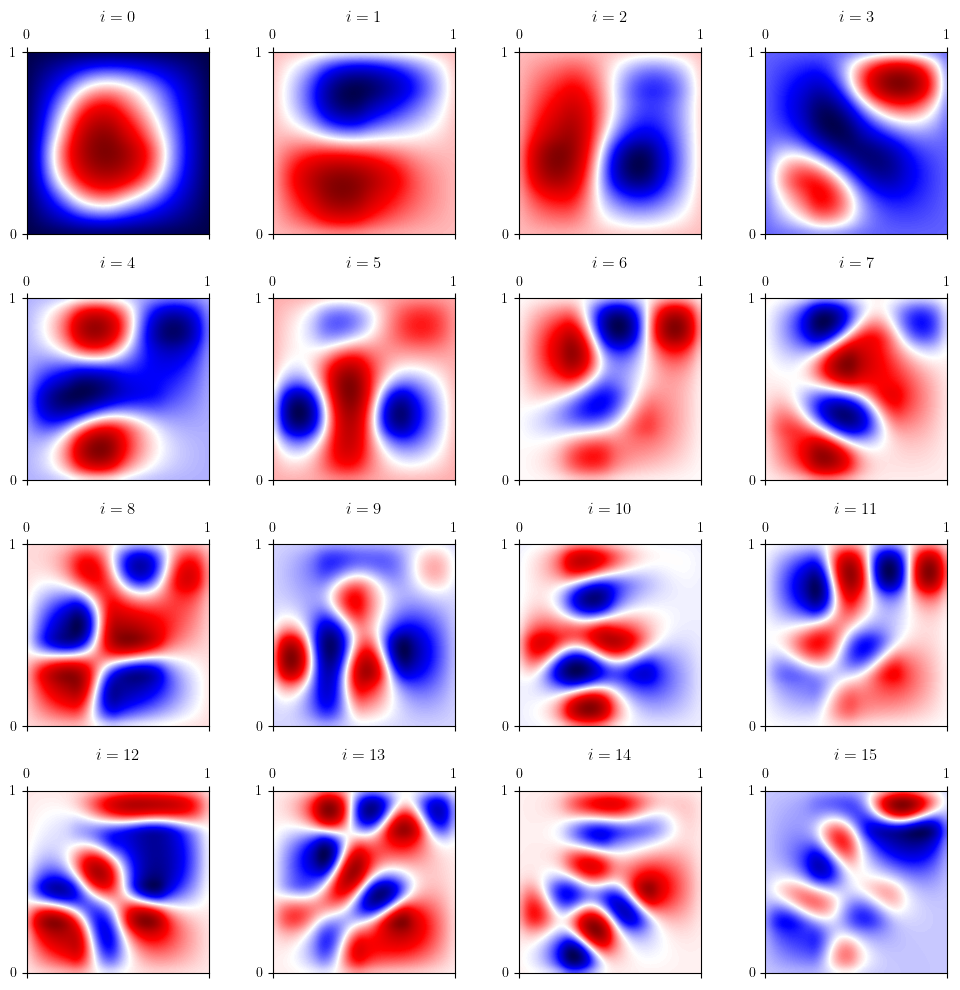

In [27]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
axes = axes.reshape(-1)
for i in range(16):
    axes[i].matshow(
        eigenvectors[:, i].reshape((N, -1)),
        extent=((0, 1, 0, 1)),
        cmap="seismic",
        interpolation="bicubic",
    )
    axes[i].set_title(fr"$i={{{i}}}$")
plt.tight_layout()
plt.savefig("1-1-nihajni_nacini.pdf")
plt.show()

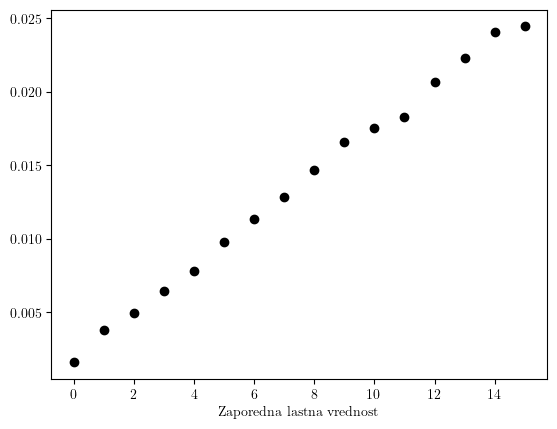

In [28]:
plt.scatter(np.arange(0, 16 ,1), eigenvalues[:16], c="k", label=r"\texttt{linalg}")
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("1-1-spekter-zoom.pdf")
plt.show()

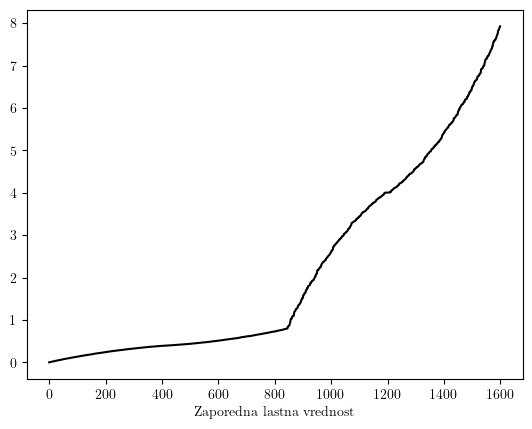

In [29]:
plt.plot( eigenvalues, c="k", label=r"\texttt{linalg}")
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("1-1-spekter.pdf")
plt.show()

In [30]:
b = np.diag(make_B(A, 10, 1).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

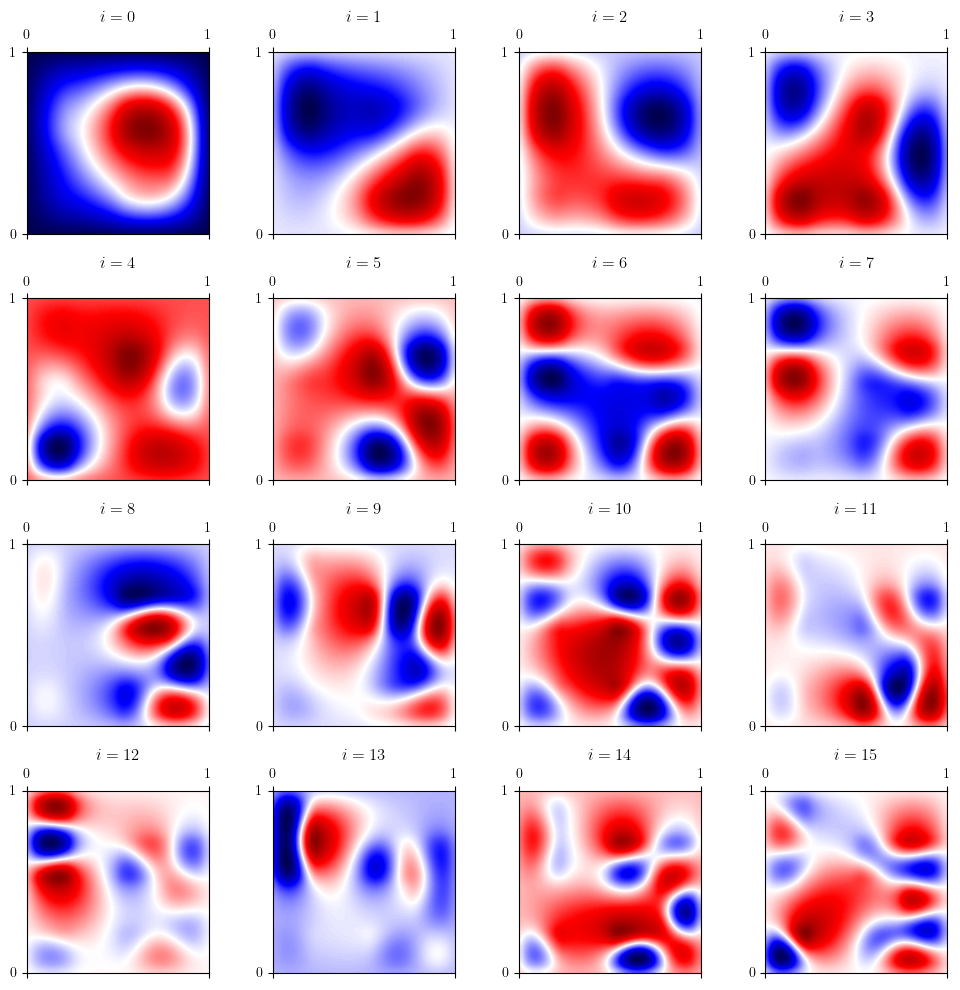

In [31]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
axes = axes.reshape(-1)
for i in range(16):
    axes[i].matshow(
        eigenvectors[:, i].reshape((N, -1)),
        extent=((0, 1, 0, 1)),
        cmap="seismic",
        interpolation="bicubic",
    )
    axes[i].set_title(fr"$i={{{i}}}$")
plt.tight_layout()
plt.savefig("1-1-nihajni_nacini_inverted.pdf")
plt.show()

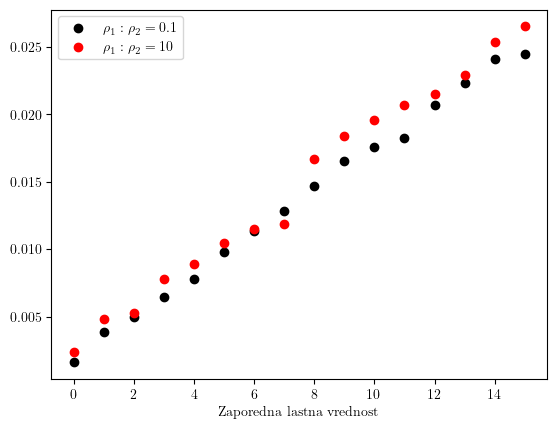

In [32]:
b = np.diag(make_B(A, 1,10).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

plt.scatter(np.arange(0, 16 ,1), eigenvalues[:16], c="k", label=r"${\rho_1}:{\rho_2} = 0.1$")

b = np.diag(make_B(A, 10,1).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

plt.scatter(np.arange(0, 16 ,1), eigenvalues[:16], c="r", label=r"${\rho_1}:{\rho_2} = 10$")
plt.legend()
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("1-1-spekter-zoom_both.pdf")
plt.show()

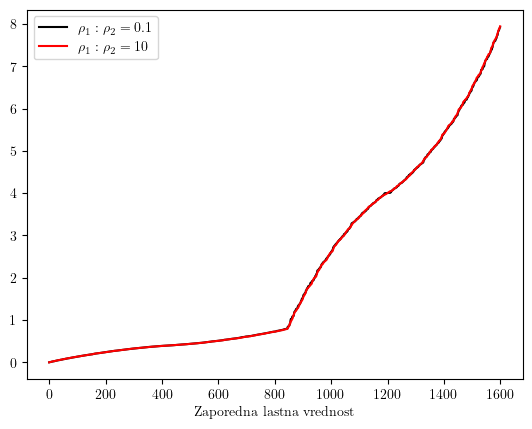

In [33]:
b = np.diag(make_B(A, 1,10).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

plt.plot(eigenvalues, c="k", label=r"${\rho_1}:{\rho_2} = 0.1$")

b = np.diag(make_B(A, 10,1).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

plt.plot(eigenvalues, c="r", label=r"${\rho_1}:{\rho_2} = 10$")
plt.legend()
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("1-1-spekter_both.pdf")
plt.show()

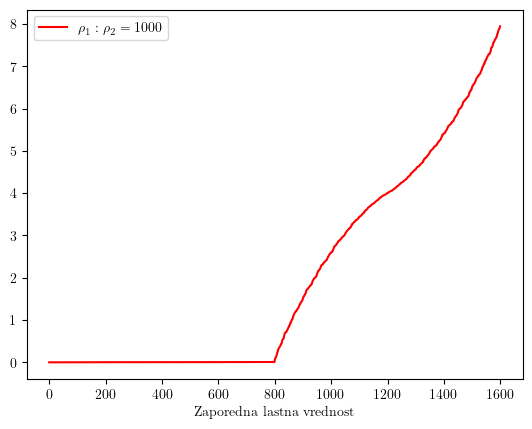

In [34]:
b = np.diag(make_B(A, 1000, 1).reshape(-1))
eigenvalues, eigenvectors = scipy.linalg.eigh(A, b)

plt.plot(eigenvalues, c="r", label=r"${\rho_1}:{\rho_2} = 1000$")
plt.legend()
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("1-1-spekter_1000.pdf")
plt.show()

0


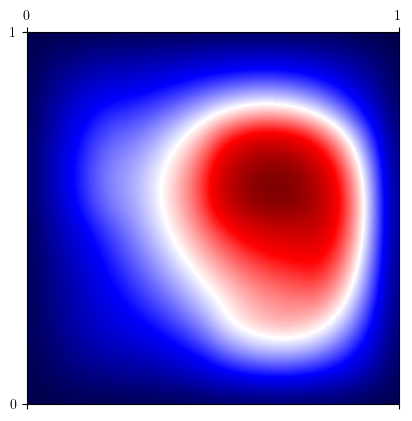

1


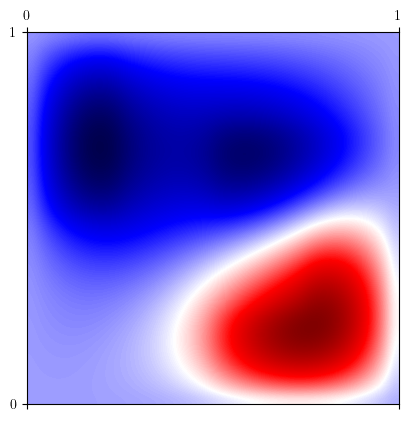

780


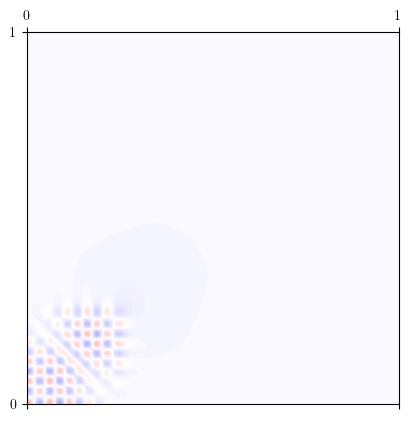

790


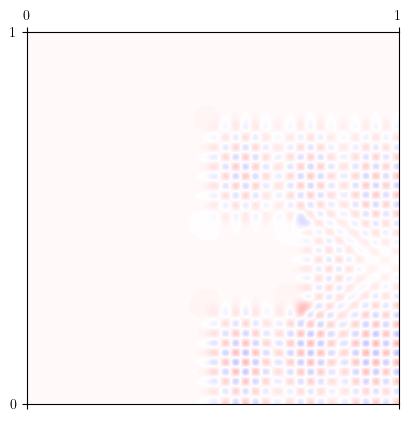

795


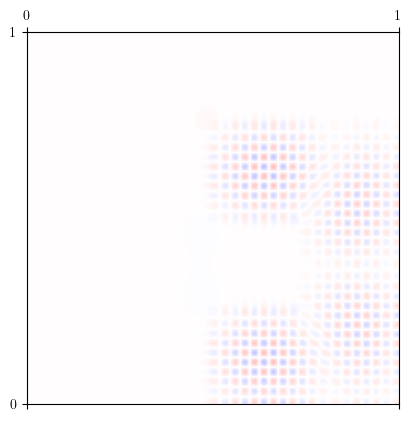

799


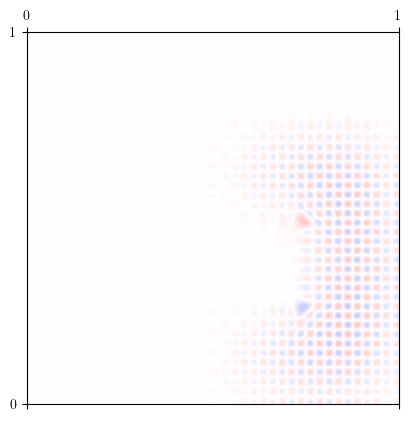

800


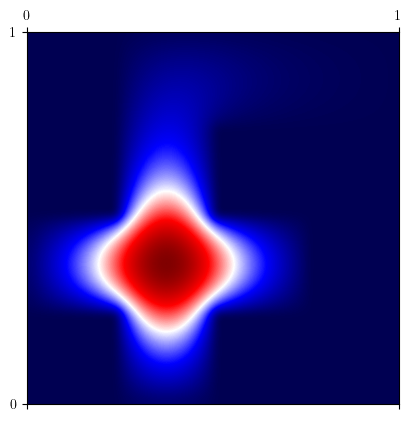

801


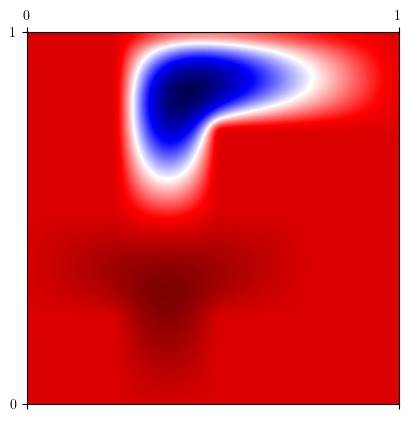

849


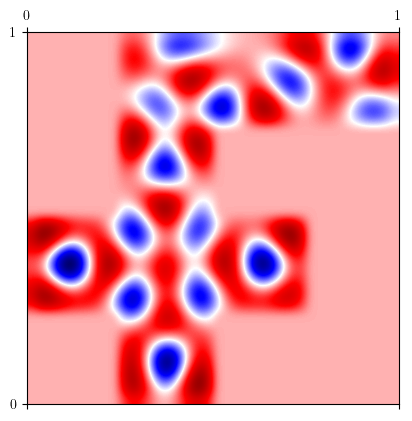

880


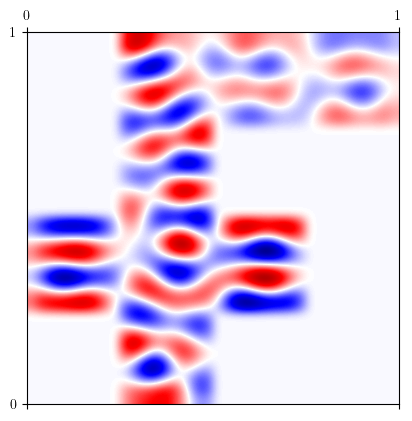

900


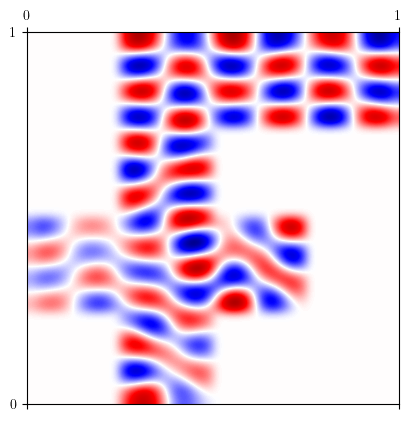

In [35]:
for i in [0, 1, 780, 790, 795, 799, 800, 801, 849, 880, 900]:
    print(i)
    plt.matshow(eigenvectors[:, i].reshape((N, -1)), extent=(0,1,0,1), cmap="seismic", interpolation="bicubic")
    plt.savefig(f"1-1-eigenmode-{i}.jpg")
    plt.show()

# Druga naloga: polkrožna opna

In [61]:
N = 40
h_r = 1 / N
h_phi = np.pi / N
rs = np.linspace(0, 1, N, endpoint=True)
phis = np.linspace(0, np.pi, N, endpoint=True)

def UU(N):
    U = np.zeros((N * N, N * N))
    for i in range(1, N * N + 1):
        U[i - 1][i - 1] = 2 * (1 / (h_r ** 2) + 1 / (h_r * h_r * h_phi * h_phi * i * i))
    for i in range(1, N * N):
        if ((N - 1) * (i - 1) - 1) % N == 0:
            U[i - 1][i] = 0
            U[i][i - 1] = 0
        else:
            U[i - 1][i] = -1 / ((h_r * i * h_phi) ** 2)
            U[i][i - 1] = -1 / ((h_r * i * h_phi) ** 2)
    for i in range(1, N * N - N + 1):
        U[i + N - 1][i - 1] = -(1 / (h_r ** 2)) - 1 / (2 * i * (h_r ** 2))
        U[i - 1][i + N - 1] = -(1 / (h_r ** 2)) + 1 / (2 * i * (h_r ** 2))
    return U


A = UU(N)

In [62]:
eigenvalues, eigenvectors = scipy.linalg.eigh(A)

In [63]:
eigenvalues_sparse, eigenvectors_sparse = scipy.sparse.linalg.eigs(A, k=6)

In [64]:
eigenvalues_sparse[0]

(653094.4841542924+0j)

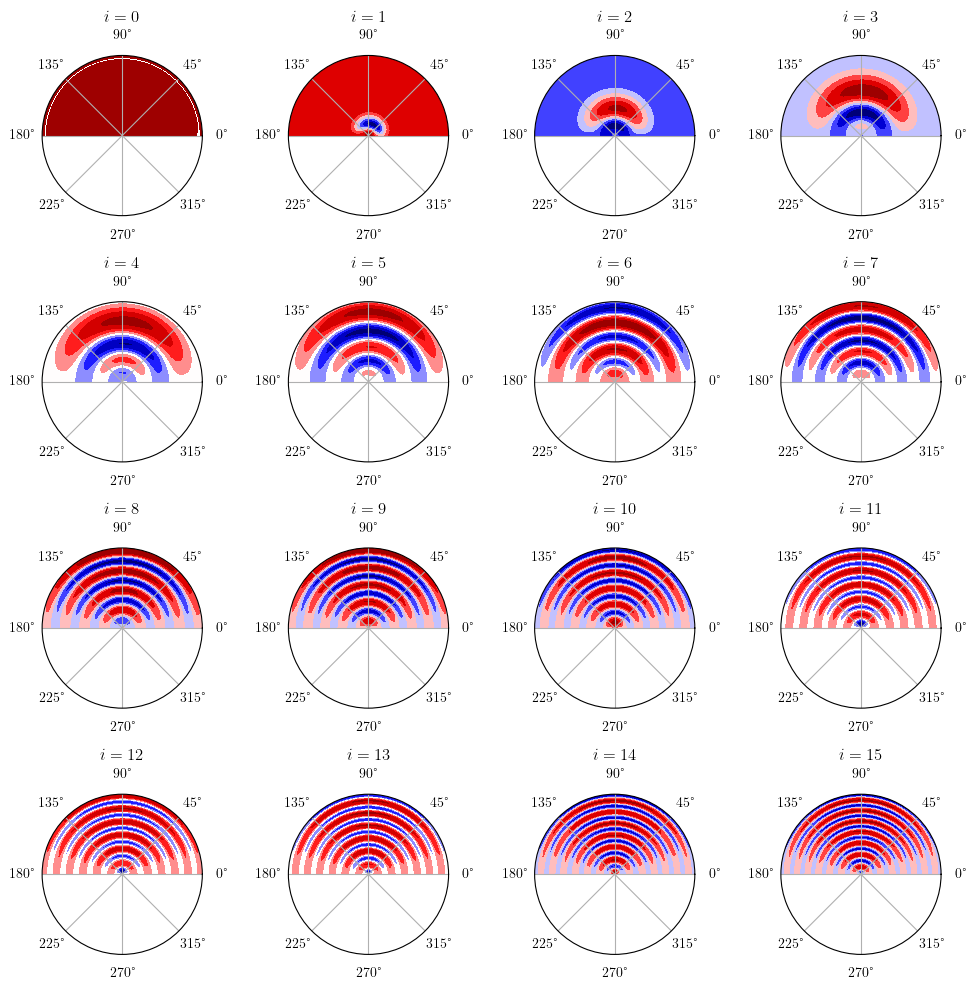

In [65]:
%matplotlib inline
rrs, phiphis = np.meshgrid(rs, phis)




fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(10, 10),subplot_kw=dict(projection='polar'))
axes = axes.reshape(-1)
for i in range(16):
    axes[i].contourf(phiphis, rrs, eigenvectors[:, i].reshape((N, -1)).astype(float), cmap="seismic")
    axes[i].set_title(fr"$i={{{i}}}$")
    axes[i].set_rlabel_position(-45)
    axes[i].set_rticks([])
plt.tight_layout()
plt.savefig("2-nihajni_nacini.pdf")
plt.show()

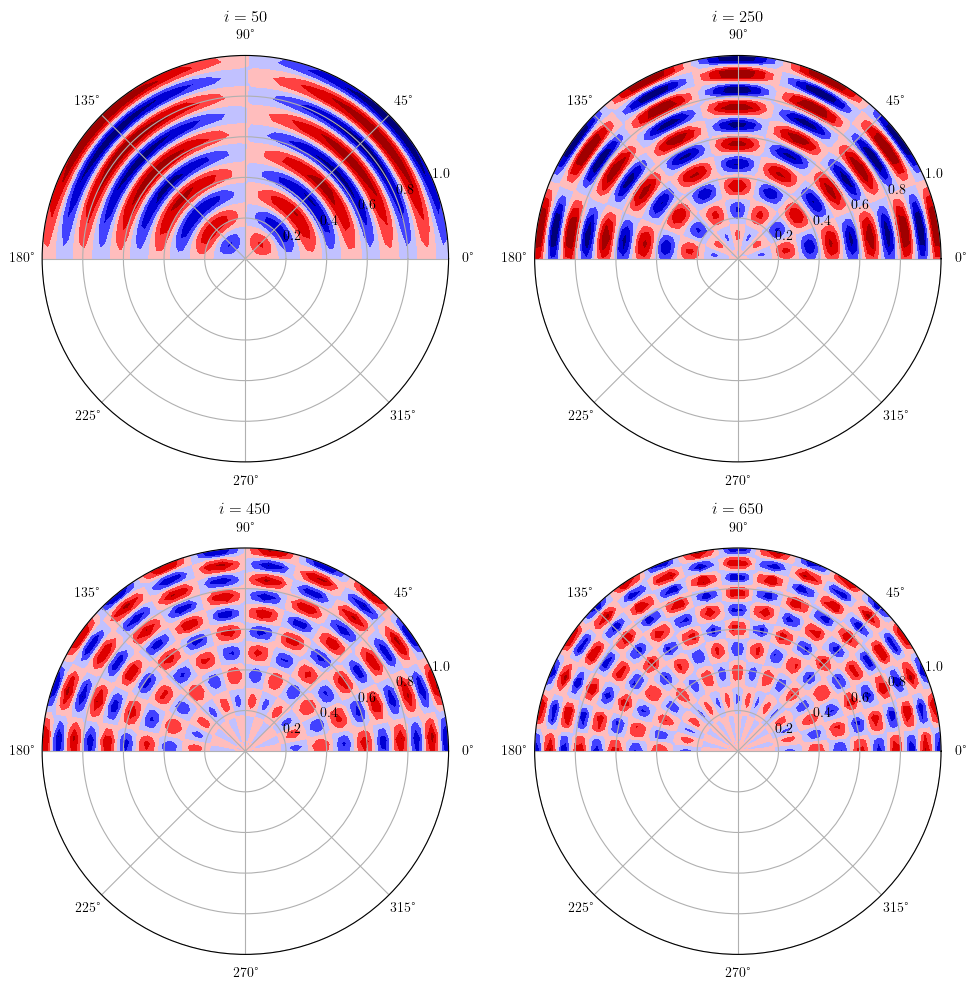

In [66]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10),subplot_kw=dict(projection='polar'))
axes = axes.reshape(-1)
indices = [50, 250, 450, 650]
for i in range(4):
    ii = indices[i]
    axes[i].contourf(phiphis, rrs, eigenvectors[:, ii].reshape((N, -1)).astype(float), cmap="seismic")
    axes[i].set_title(fr"$i={{{ii}}}$")
plt.tight_layout()
plt.savefig("2-nihajni_nacini_miks.pdf")
plt.show()

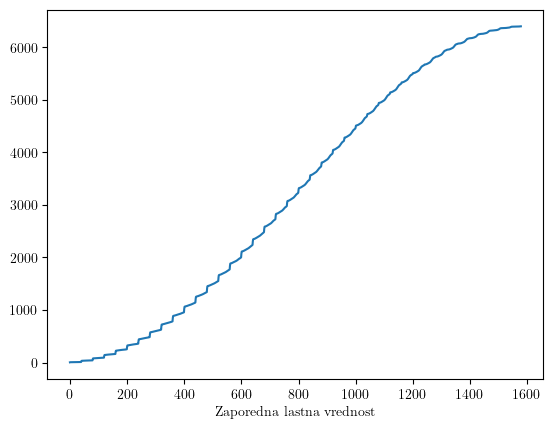

In [67]:
plt.plot(eigenvalues[1:-20])
plt.xlabel("Zaporedna lastna vrednost")
plt.savefig("2-spekter.pdf")
plt.show()

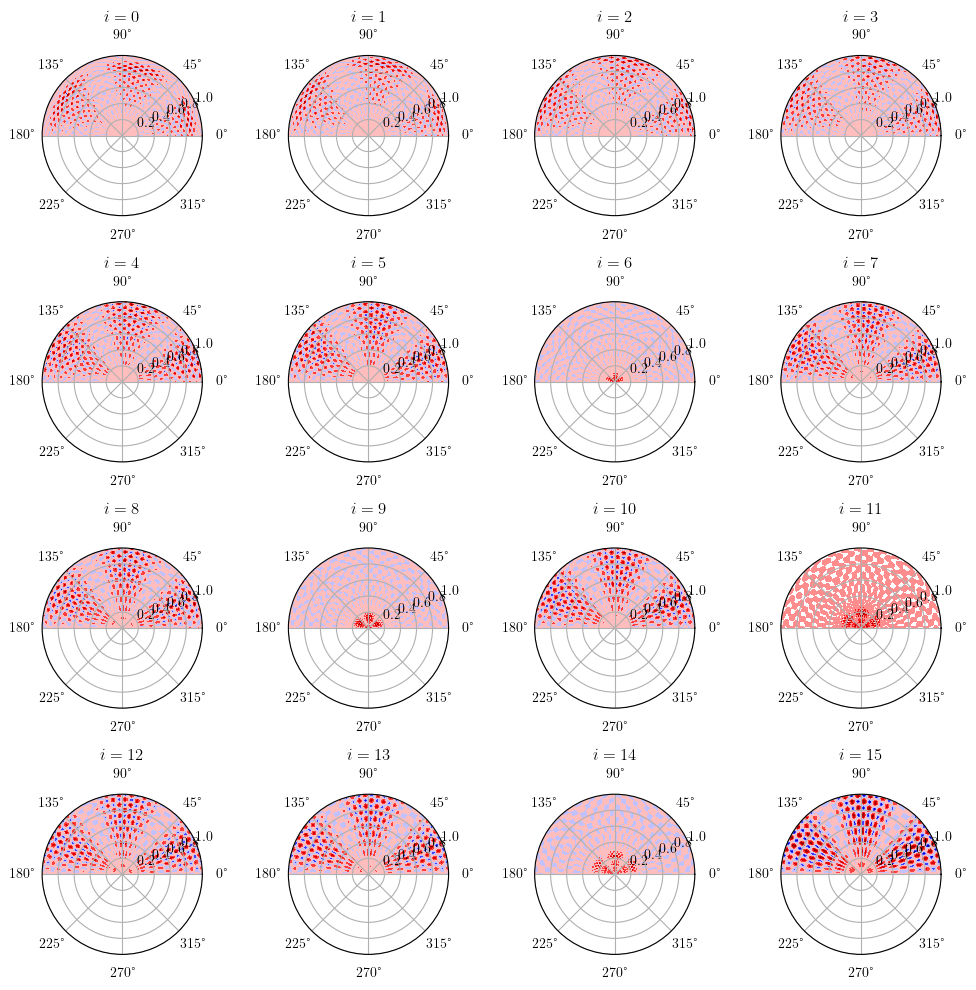

In [68]:
rrs, phiphis = np.meshgrid(rs, phis)




fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(10, 10),subplot_kw=dict(projection='polar'))
axes = axes.reshape(-1)
for i in range(16):
    axes[i].contourf(phiphis, rrs, eigenvectors[:, -i-100].reshape((N, -1)).astype(float), cmap="seismic")
    axes[i].set_title(fr"$i={{{i}}}$")
plt.tight_layout()
#plt.savefig("2-nihajni_nacini.pdf")
plt.show()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection='polar'))
ax.contourf(phiphis, rrs, eigenvectors[:, -111].reshape((N, -1)).astype(float), cmap="seismic")
plt.show()

libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
